## Compare CatBoost in the case of binary class (Sell, Buy)

In [76]:
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline

In [77]:
spy = pd.read_csv("../data/raw/spy.csv", parse_dates=True, index_col=0)

In [78]:
target = pd.read_csv("../data/processed/target_df.csv", parse_dates=True, index_col=0)[
    "target"
]

In [79]:
ml_df = pd.read_csv("../data/processed/ml_df.csv", parse_dates=True, index_col=0)

In [80]:
wk_df = pd.read_csv("../data/processed/exp_price.csv", parse_dates=True, index_col=0)

In [81]:
interest_rate = wk_df["r"].values

### Functions

In [82]:
def display_report(y_test: np.ndarray, predictions: np.ndarray) -> None:
    print(classification_report(y_test, predictions))
    cm = confusion_matrix(y_test, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()
    return

In [83]:
def plot_feature_imp(coefficients: np.ndarray[float], columns: list[str]) -> None:
    feature_importance = pd.DataFrame(
        {"Feature": columns, "Importance": np.abs(coefficients)}
    )
    feature_importance = feature_importance.sort_values("Importance", ascending=True)
    feature_importance.plot(x="Feature", y="Importance", kind="barh", figsize=(10, 6))
    plt.show()
    return

## Baseline CatBoost Classifier without new data + r

In [84]:
orig_df = ml_df[
    [
        "UNDERLYING_LAST",
        "STRIKE",
        "C_LAST",
        "C_BID",
        "C_ASK",
        "C_IV",
        "C_VOLUME",
        "diff_date",
    ]
].copy()

In [85]:
orig_df["r"] = interest_rate

### In sample predictions

In [86]:
X_train, X_test, y_train, y_test = train_test_split(
    orig_df, target.values.flatten(), test_size=0.2, random_state=1968, shuffle=True
)

### Hyper-parameters tuning using Optuna

In [87]:
# Adapted from https://github.com/optuna/optuna-examples/blob/main/catboost/catboost_pruning.py
def objective(trial: optuna.Trial) -> float:
    param = {
        "objective": trial.suggest_categorical(
            "objective", ["Logloss", "CrossEntropy"]
        ),
        "colsample_bylevel": trial.suggest_float(
            "colsample_bylevel", 0.01, 0.1, log=True
        ),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical(
            "boosting_type", ["Ordered", "Plain"]
        ),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 2, 10),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
        "eval_metric": "Recall",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1, log=True)

    model = Pipeline(
        [
            ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
            (
                "rf",
                CatBoostClassifier(
                    **param, silent=True, early_stopping_rounds=50, random_state=1968
                ),
            ),
        ]
    )

    cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=1968)

    return cross_val_score(
        model, X_train, y_train, cv=cv, scoring="recall", n_jobs=1
    ).mean()

In [88]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=150, timeout=600)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-02-12 12:23:03,387] A new study created in memory with name: no-name-ceea2752-1ff7-49c5-b507-a4f7d92b58f9
[I 2024-02-12 12:23:05,861] Trial 0 finished with value: 0.004201680672268907 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.06306680371165817, 'learning_rate': 0.0014395786811174775, 'depth': 1, 'boosting_type': 'Plain', 'l2_leaf_reg': 7, 'min_data_in_leaf': 46, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 8.217681214587332}. Best is trial 0 with value: 0.004201680672268907.
[I 2024-02-12 12:23:13,062] Trial 1 finished with value: 0.5135329131652661 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.026361663140738147, 'learning_rate': 0.08666253446599047, 'depth': 9, 'boosting_type': 'Ordered', 'l2_leaf_reg': 10, 'min_data_in_leaf': 96, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.5673265392817344}. Best is trial 1 with value: 0.5135329131652661.
[I 2024-02-12 12:23:19,496] Trial 2 finished with value: 0.42121848739495793 an

Number of finished trials: 150
Best trial:
  Value: 0.6981267507002802
  Params: 
    objective: CrossEntropy
    colsample_bylevel: 0.0999860259866223
    learning_rate: 0.0657093866190851
    depth: 6
    boosting_type: Plain
    l2_leaf_reg: 5
    min_data_in_leaf: 93
    bootstrap_type: MVS


In [89]:
print("Best hyperparameters:", study.best_params)
print("Best score:", study.best_value)

Best hyperparameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.0999860259866223, 'learning_rate': 0.0657093866190851, 'depth': 6, 'boosting_type': 'Plain', 'l2_leaf_reg': 5, 'min_data_in_leaf': 93, 'bootstrap_type': 'MVS'}
Best score: 0.6981267507002802


In [90]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        ("rf", CatBoostClassifier(**study.best_params, silent=True)),
    ]
)

In [91]:
# Fit the tuned model
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('rf',
                 <catboost.core.CatBoostClassifier object at 0x13607bed0>)])

In [92]:
predictions = pipe.predict(X_test)

In [93]:
pipe.score(X_test, y_test)

0.6653386454183267

              precision    recall  f1-score   support

           0       0.64      0.72      0.68       123
           1       0.69      0.62      0.65       128

    accuracy                           0.67       251
   macro avg       0.67      0.67      0.66       251
weighted avg       0.67      0.67      0.66       251



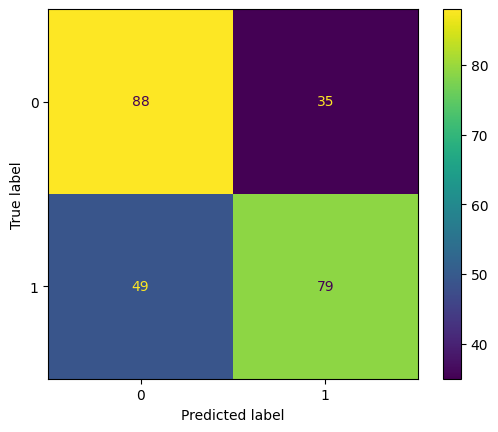

In [94]:
display_report(y_test, predictions)

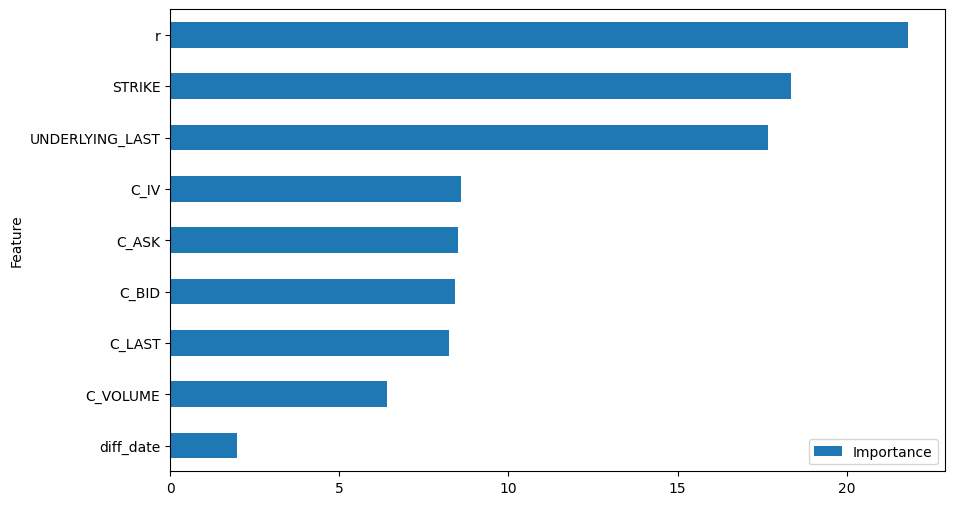

In [95]:
coefficients = pipe.named_steps["rf"].feature_importances_
columns = orig_df.columns
plot_feature_imp(coefficients, columns)

In [96]:
compare_df = pd.DataFrame(predictions, columns=["bare_rf_pred_in"])

### Backtesting

In [97]:
strategy = []
date_idx = []
prev_price = 0.0
for x, i in enumerate(range(len(predictions), 0, -1)):
    row = X_test.iloc[-i, :].to_dict()
    quote_date = X_test.index[-i]
    exp_date = pd.to_datetime(ml_df.loc[quote_date, "EXPIRE_DATE"])
    # Needed since a day in YF is missing
    try:
        final_price = spy.loc[exp_date, "Close"]
    except KeyError:
        final_price = prev_price
    prev_price = final_price
    call_price = row["C_LAST"]
    strike = row["STRIKE"]
    if predictions[x]:  # buy
        if final_price > strike:
            profit = final_price - (strike + call_price)
        else:
            profit = -call_price
        res = {
            "strategy": predictions[x],
            "strike": strike,
            "call_price": row["C_LAST"],
            "exp_date": ml_df.loc[quote_date, "EXPIRE_DATE"],
            "final_price": final_price,
            "profit": profit,
            "bare": max(final_price - (strike + call_price), -call_price),
        }
    else:
        res = {
            "strategy": predictions[x],
            "strike": strike,
            "call_price": row["C_LAST"],
            "exp_date": ml_df.loc[quote_date, "EXPIRE_DATE"],
            "final_price": final_price,
            "profit": 0.0,
            "bare": max(final_price - (strike + call_price), -call_price),
        }
    strategy.append(res)
    date_idx.append(quote_date)

In [98]:
strategy_df = pd.DataFrame(strategy, pd.Index(name="Date", data=date_idx))

strategy_df = strategy_df.sort_index()

In [99]:
strategy_df["cum_profit"] = np.cumsum(strategy_df.profit.values)
strategy_df["cum_bare"] = np.cumsum(strategy_df.bare.values)

In [100]:
strategy_df

,strategy,strike,call_price,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,
2018-02-05,0,265.0,8.22,2018-02-28,271.649994,0.000000,-1.570006,0.000000,-1.570006
2018-02-22,0,270.0,4.26,2018-03-14,275.299988,0.000000,1.039988,0.000000,-0.530018
2018-03-08,0,274.0,2.85,2018-03-29,263.149994,0.000000,-2.850000,0.000000,-3.380018
2018-03-09,0,279.0,2.47,2018-03-29,263.149994,0.000000,-2.470000,0.000000,-5.850018
2018-04-03,1,260.5,5.09,2018-04-23,266.570007,0.980007,0.980007,0.980007,-4.870011
...,...,...,...,...,...,...,...,...,...
2022-10-25,0,385.0,10.50,2022-11-14,395.119995,0.000000,-0.380005,365.729923,389.189830
2022-11-01,1,385.0,9.48,2022-11-21,394.589996,0.109996,0.109996,365.839919,389.299827
2022-11-02,1,375.0,10.19,2022-11-23,402.420013,17.230013,17.230013,383.069933,406.529840


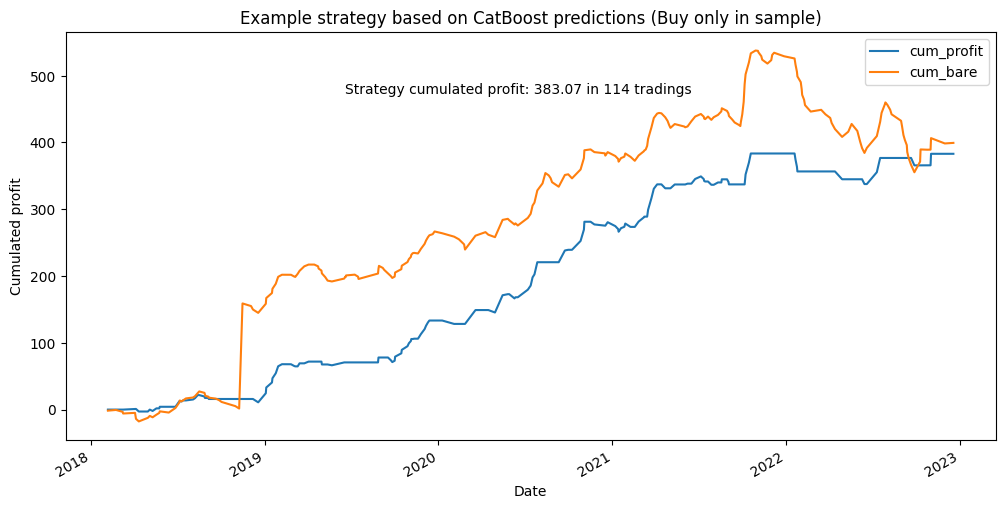

In [101]:
strategy_df[["cum_profit", "cum_bare"]].plot(
    figsize=(12, 6),
    ylabel="Cumulated profit",
    title="Example strategy based on CatBoost predictions (Buy only in sample)",
)
ax = plt.gca()
text = f"Strategy cumulated profit: {strategy_df['cum_profit'].iloc[-1]:.2f} in {strategy_df['strategy'].sum()} tradings"
plt.text(0.3, 0.85, text, transform=ax.transAxes)
plt.legend()
plt.show()

### Out-of-sample predictions

In [102]:
X_train, X_test, y_train, y_test = train_test_split(
    orig_df.values,
    target.values.flatten(),
    test_size=0.2,
    random_state=1968,
    shuffle=False,
)

In [103]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        ("rf", CatBoostClassifier(**study.best_params, silent=True)),
    ]
)

In [104]:
# Fit the tuned model
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('rf',
                 <catboost.core.CatBoostClassifier object at 0x1368e4f50>)])

In [105]:
predictions = pipe.predict(X_test)

In [106]:
pipe.score(X_test, y_test)

0.5976095617529881

              precision    recall  f1-score   support

           0       0.69      0.79      0.73       177
           1       0.21      0.14      0.17        74

    accuracy                           0.60       251
   macro avg       0.45      0.46      0.45       251
weighted avg       0.55      0.60      0.57       251



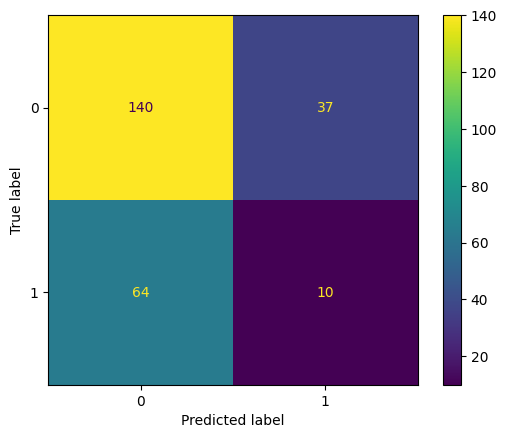

In [107]:
display_report(y_test, predictions)

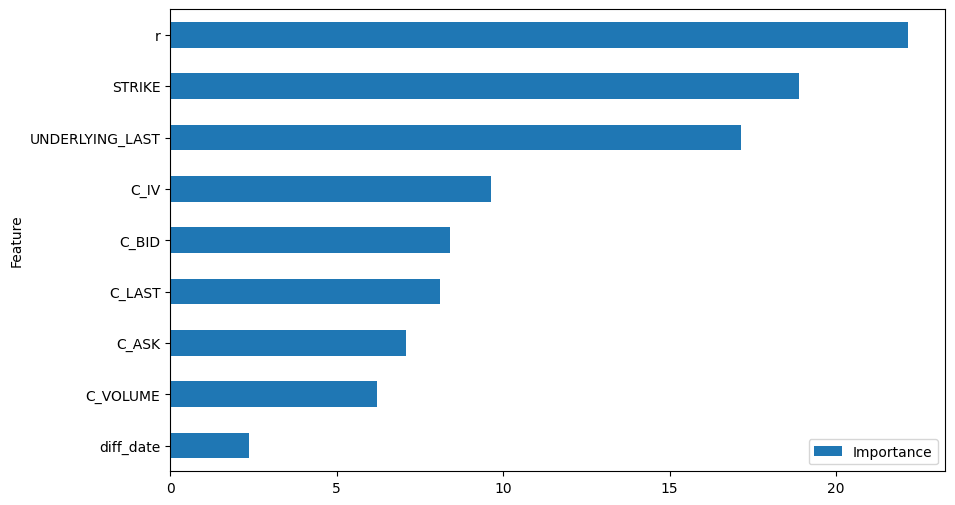

In [108]:
coefficients = pipe.named_steps["rf"].feature_importances_
columns = orig_df.columns
plot_feature_imp(coefficients, columns)

In [109]:
compare_df["bare_rf_pred_out"] = predictions

### Backtesting

In [110]:
strategy = []
date_idx = []
for x, i in enumerate(range(len(predictions), 0, -1)):
    row = orig_df.iloc[-i, :].to_dict()
    quote_date = orig_df.index[-i]
    exp_date = pd.to_datetime(ml_df.loc[quote_date, "EXPIRE_DATE"])
    final_price = spy.loc[exp_date, "Close"]
    call_price = row["C_LAST"]
    strike = row["STRIKE"]
    if predictions[x]:  # buy
        if final_price > strike:
            profit = final_price - (strike + call_price)
        else:
            profit = -call_price
        res = {
            "strategy": predictions[x],
            "strike": strike,
            "call_price": row["C_LAST"],
            "exp_date": ml_df.loc[quote_date, "EXPIRE_DATE"],
            "final_price": final_price,
            "profit": profit,
            "bare": max(final_price - (strike + call_price), -call_price),
        }
    else:
        res = {
            "strategy": predictions[x],
            "strike": strike,
            "call_price": row["C_LAST"],
            "exp_date": ml_df.loc[quote_date, "EXPIRE_DATE"],
            "final_price": final_price,
            "profit": 0.0,
            "bare": max(final_price - (strike + call_price), -call_price),
        }
    strategy.append(res)
    date_idx.append(quote_date)

In [111]:
strategy_df = pd.DataFrame(strategy, pd.Index(name="Date", data=date_idx))

In [112]:
strategy_df["cum_profit"] = np.cumsum(strategy_df.profit.values)
strategy_df["cum_bare"] = np.cumsum(strategy_df.bare.values)

In [113]:
strategy_df

,strategy,strike,call_price,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,
2022-01-03,0,478.0,4.81,2022-01-24,439.839996,0.0,-4.810000,0.000000,-4.810000
2022-01-04,0,478.0,4.80,2022-01-24,439.839996,0.0,-4.800000,0.000000,-9.610000
2022-01-05,0,468.0,8.14,2022-01-26,433.380005,0.0,-8.140000,0.000000,-17.750000
2022-01-06,0,468.0,7.00,2022-01-26,433.380005,0.0,-7.000000,0.000000,-24.750000
2022-01-07,0,466.0,7.56,2022-01-28,441.950012,0.0,-7.560000,0.000000,-32.310000
...,...,...,...,...,...,...,...,...,...
2022-12-23,0,383.0,8.00,2023-01-13,398.500000,0.0,7.500000,-212.300037,-525.980022
2022-12-26,0,383.0,7.96,2023-01-13,398.500000,0.0,7.540000,-212.300037,-518.440022
2022-12-28,0,377.0,8.75,2023-01-20,395.880005,0.0,10.130005,-212.300037,-508.310017


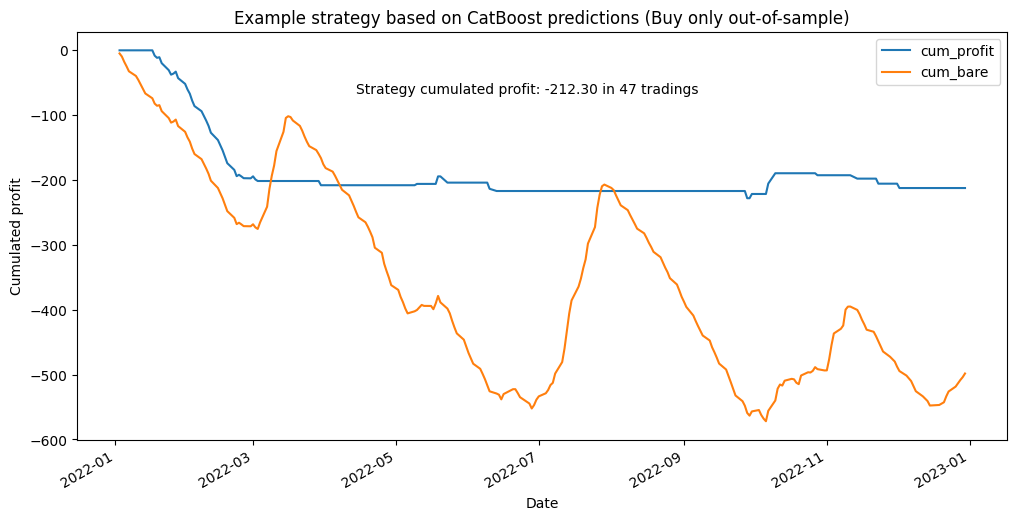

In [114]:
strategy_df[["cum_profit", "cum_bare"]].plot(
    figsize=(12, 6),
    ylabel="Cumulated profit",
    title="Example strategy based on CatBoost predictions (Buy only out-of-sample)",
)
ax = plt.gca()
text = f"Strategy cumulated profit: {strategy_df['cum_profit'].iloc[-1]:.2f} in {strategy_df['strategy'].sum()} tradings"
plt.text(0.3, 0.85, text, transform=ax.transAxes)
plt.legend()
plt.show()

## CatBoost with data from MC simulation and additional features

In [115]:
new_df = pd.concat(
    (
        ml_df[
            [
                "UNDERLYING_LAST",
                "STRIKE",
                "C_LAST",
                "C_BID",
                "C_ASK",
                "C_IV",
                "C_VOLUME",
                "diff",
            ]
        ],
        wk_df.drop(["last_quote", "strike"], axis=1),
    ),
    axis=1,
)

In [116]:
# Add some features
new_df["iqr"] = new_df["exp_price_q3"] - new_df["exp_price_q1"]
new_df["diff_call"] = new_df["exp_call_price"] - new_df["C_LAST"]
new_df["exp_price_var"] = np.power(new_df["exp_price_std"], 2)
new_df["exp_profit"] = new_df["exp_price"] - (new_df["STRIKE"] + new_df["C_LAST"])

### In-sample predictions

In [117]:
X_train, X_test, y_train, y_test = train_test_split(
    new_df, target.values.flatten(), test_size=0.2, random_state=1968, shuffle=True
)

### Hyper-parameters tuning using Optuna

In [118]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=150, timeout=1200)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-02-12 12:32:34,088] A new study created in memory with name: no-name-01356756-6d26-453e-9d71-8b43c76dc173
[I 2024-02-12 12:32:36,167] Trial 0 finished with value: 0.5007878151260504 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.014474678079416617, 'learning_rate': 0.01811845698834403, 'depth': 3, 'boosting_type': 'Plain', 'l2_leaf_reg': 8, 'min_data_in_leaf': 35, 'bootstrap_type': 'Bernoulli', 'subsample': 0.4465468360515623}. Best is trial 0 with value: 0.5007878151260504.
[I 2024-02-12 12:32:42,979] Trial 1 finished with value: 0.25115546218487395 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.017453371881787607, 'learning_rate': 0.005869267307274518, 'depth': 12, 'boosting_type': 'Ordered', 'l2_leaf_reg': 5, 'min_data_in_leaf': 94, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 7.508190641889754}. Best is trial 0 with value: 0.5007878151260504.
[I 2024-02-12 12:32:44,716] Trial 2 finished with value: 0.6309348739495798 and p

Number of finished trials: 50
Best trial:
  Value: 0.7820378151260504
  Params: 
    objective: CrossEntropy
    colsample_bylevel: 0.08274450286889667
    learning_rate: 0.08713461123662804
    depth: 12
    boosting_type: Ordered
    l2_leaf_reg: 8
    min_data_in_leaf: 76
    bootstrap_type: Bernoulli
    subsample: 0.5240736780358749


In [119]:
print("Best hyperparameters:", study.best_params)
print("Best score:", study.best_value)

Best hyperparameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.08274450286889667, 'learning_rate': 0.08713461123662804, 'depth': 12, 'boosting_type': 'Ordered', 'l2_leaf_reg': 8, 'min_data_in_leaf': 76, 'bootstrap_type': 'Bernoulli', 'subsample': 0.5240736780358749}
Best score: 0.7820378151260504


In [120]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        ("rf", CatBoostClassifier(**study.best_params, silent=True)),
    ]
)

In [121]:
# Fit the tuned model
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('rf',
                 <catboost.core.CatBoostClassifier object at 0x136a53210>)])

In [122]:
predictions = pipe.predict(X_test)

In [123]:
pipe.score(X_test, y_test)

0.749003984063745

              precision    recall  f1-score   support

           0       0.72      0.79      0.75       123
           1       0.78      0.71      0.74       128

    accuracy                           0.75       251
   macro avg       0.75      0.75      0.75       251
weighted avg       0.75      0.75      0.75       251



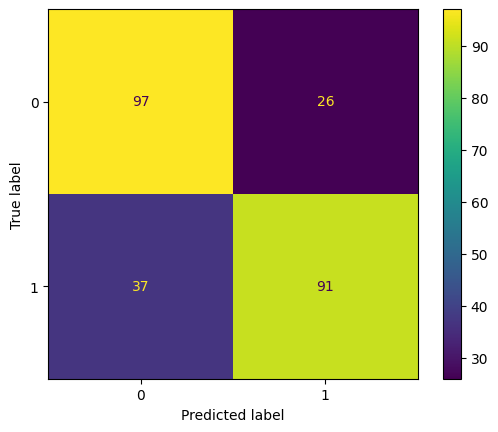

In [124]:
display_report(y_test, predictions)

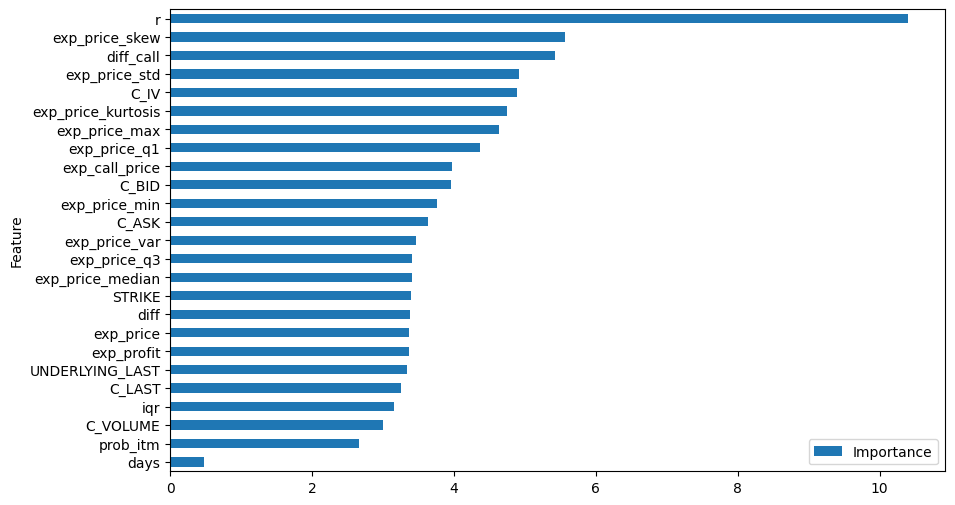

In [125]:
coefficients = pipe.named_steps["rf"].feature_importances_
columns = new_df.columns
plot_feature_imp(coefficients, columns)

In [126]:
compare_df["mmar_rf_pred_in"] = predictions

### Backtesting

In [127]:
strategy = []
date_idx = []
prev_price = 0.0
for x, i in enumerate(range(len(predictions), 0, -1)):
    row = X_test.iloc[-i, :].to_dict()
    quote_date = X_test.index[-i]
    exp_date = pd.to_datetime(ml_df.loc[quote_date, "EXPIRE_DATE"])
    # Needed since a day in YF is missing
    try:
        final_price = spy.loc[exp_date, "Close"]
    except KeyError:
        final_price = prev_price
    prev_price = final_price
    call_price = row["C_LAST"]
    strike = row["STRIKE"]
    if predictions[x]:  # buy
        if final_price > strike:
            profit = final_price - (strike + call_price)
        else:
            profit = -call_price
        res = {
            "strategy": predictions[x],
            "strike": strike,
            "call_price": row["C_LAST"],
            "exp_call": row["exp_call_price"],
            "exp_date": ml_df.loc[quote_date, "EXPIRE_DATE"],
            "final_price": final_price,
            "profit": profit,
            "bare": max(final_price - (strike + call_price), -call_price),
        }
    else:
        res = {
            "strategy": predictions[x],
            "strike": strike,
            "call_price": row["C_LAST"],
            "exp_call": row["exp_call_price"],
            "exp_date": ml_df.loc[quote_date, "EXPIRE_DATE"],
            "final_price": final_price,
            "profit": 0.0,
            "bare": max(final_price - (strike + call_price), -call_price),
        }
    strategy.append(res)
    date_idx.append(quote_date)

In [128]:
strategy_df = pd.DataFrame(strategy, pd.Index(name="Date", data=date_idx))

strategy_df = strategy_df.sort_index()

In [129]:
strategy_df["cum_profit"] = np.cumsum(strategy_df.profit.values)
strategy_df["cum_bare"] = np.cumsum(strategy_df.bare.values)

In [130]:
strategy_df

,strategy,strike,call_price,exp_call,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,,
2018-02-05,1,265.0,8.22,4.942161,2018-02-28,271.649994,-1.570006,-1.570006,-1.570006,-1.570006
2018-02-22,0,270.0,4.26,6.397086,2018-03-14,275.299988,0.000000,1.039988,-1.570006,-0.530018
2018-03-08,0,274.0,2.85,5.917690,2018-03-29,263.149994,0.000000,-2.850000,-1.570006,-3.380018
2018-03-09,0,279.0,2.47,5.505012,2018-03-29,263.149994,0.000000,-2.470000,-1.570006,-5.850018
2018-04-03,1,260.5,5.09,5.247430,2018-04-23,266.570007,0.980007,0.980007,-0.589999,-4.870011
...,...,...,...,...,...,...,...,...,...,...
2022-10-25,0,385.0,10.50,9.062317,2022-11-14,395.119995,0.000000,-0.380005,519.329818,389.189830
2022-11-01,1,385.0,9.48,8.719475,2022-11-21,394.589996,0.109996,0.109996,519.439814,389.299827
2022-11-02,0,375.0,10.19,8.901524,2022-11-23,402.420013,0.000000,17.230013,519.439814,406.529840


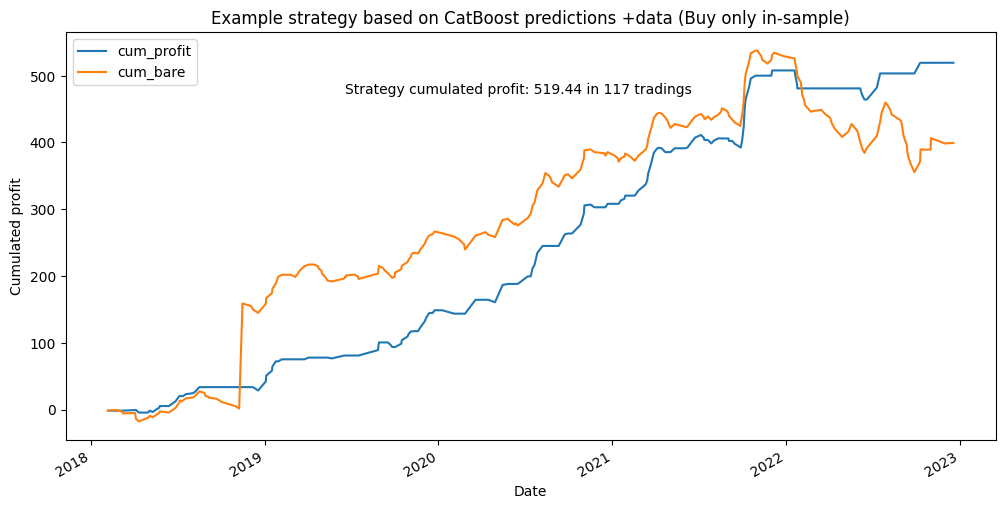

In [131]:
strategy_df[["cum_profit", "cum_bare"]].plot(
    figsize=(12, 6),
    ylabel="Cumulated profit",
    title="Example strategy based on CatBoost predictions +data (Buy only in-sample)",
)
ax = plt.gca()
text = f"Strategy cumulated profit: {strategy_df['cum_profit'].iloc[-1]:.2f} in {strategy_df['strategy'].sum()} tradings"
plt.text(0.3, 0.85, text, transform=ax.transAxes)
plt.legend()
plt.show()

### Out-of-sample predictions

In [132]:
X_train, X_test, y_train, y_test = train_test_split(
    new_df.values,
    target.values.flatten(),
    test_size=0.2,
    random_state=1968,
    shuffle=False,
)

In [133]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        ("rf", CatBoostClassifier(**study.best_params, silent=True)),
    ]
)

In [134]:
# Fit the tuned model
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('rf',
                 <catboost.core.CatBoostClassifier object at 0x136733750>)])

In [135]:
predictions = pipe.predict(X_test)

In [136]:
pipe.score(X_test, y_test)

0.4063745019920319

              precision    recall  f1-score   support

           0       0.89      0.18      0.30       177
           1       0.33      0.95      0.48        74

    accuracy                           0.41       251
   macro avg       0.61      0.56      0.39       251
weighted avg       0.72      0.41      0.35       251



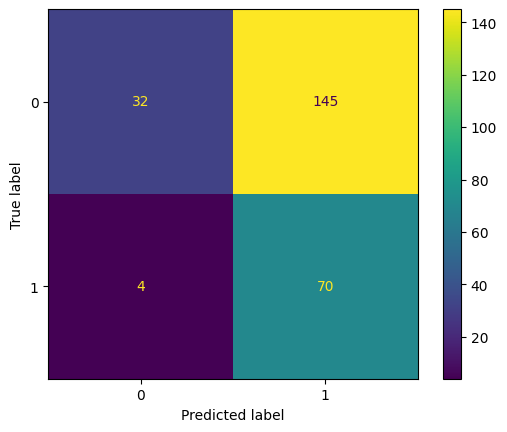

In [137]:
display_report(y_test, predictions)

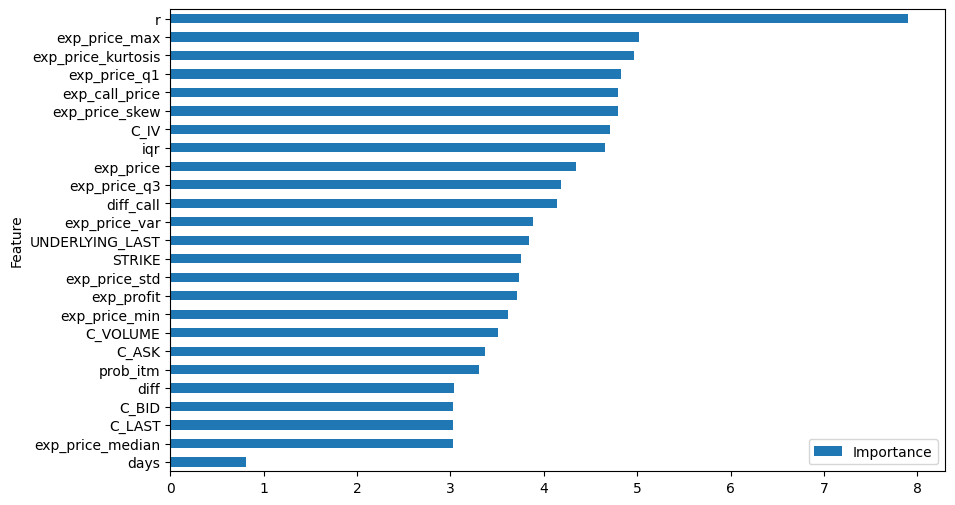

In [138]:
coefficients = pipe.named_steps["rf"].feature_importances_
columns = new_df.columns
plot_feature_imp(coefficients, columns)

In [139]:
compare_df["mmar_rf_pred_out"] = predictions

### Backtesting

In [140]:
strategy = []
date_idx = []
for x, i in enumerate(range(len(predictions), 0, -1)):
    row = new_df.iloc[-i, :].to_dict()
    quote_date = new_df.index[-i]
    exp_date = pd.to_datetime(ml_df.loc[quote_date, "EXPIRE_DATE"])
    final_price = spy.loc[exp_date, "Close"]
    call_price = row["C_LAST"]
    strike = row["STRIKE"]
    if predictions[x]:  # buy
        if final_price > strike:
            profit = final_price - (strike + call_price)
        else:
            profit = -call_price
        res = {
            "strategy": predictions[x],
            "strike": strike,
            "call_price": row["C_LAST"],
            "exp_call": row["exp_call_price"],
            "exp_date": ml_df.loc[quote_date, "EXPIRE_DATE"],
            "final_price": final_price,
            "profit": profit,
            "bare": max(final_price - (strike + call_price), -call_price),
        }
    else:
        res = {
            "strategy": predictions[x],
            "strike": strike,
            "call_price": row["C_LAST"],
            "exp_call": row["exp_call_price"],
            "exp_date": ml_df.loc[quote_date, "EXPIRE_DATE"],
            "final_price": final_price,
            "profit": 0.0,
            "bare": max(final_price - (strike + call_price), -call_price),
        }
    strategy.append(res)
    date_idx.append(quote_date)

In [141]:
strategy_df = pd.DataFrame(strategy, pd.Index(name="Date", data=date_idx))

In [142]:
strategy_df["cum_profit"] = np.cumsum(strategy_df.profit.values)
strategy_df["cum_bare"] = np.cumsum(strategy_df.bare.values)

In [143]:
strategy_df

,strategy,strike,call_price,exp_call,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,,
2022-01-03,0,478.0,4.81,10.248337,2022-01-24,439.839996,0.000000,-4.810000,0.000000,-4.810000
2022-01-04,0,478.0,4.80,9.610177,2022-01-24,439.839996,0.000000,-4.800000,0.000000,-9.610000
2022-01-05,1,468.0,8.14,10.191128,2022-01-26,433.380005,-8.140000,-8.140000,-8.140000,-17.750000
2022-01-06,1,468.0,7.00,9.657596,2022-01-26,433.380005,-7.000000,-7.000000,-15.140000,-24.750000
2022-01-07,1,466.0,7.56,9.927762,2022-01-28,441.950012,-7.560000,-7.560000,-22.700000,-32.310000
...,...,...,...,...,...,...,...,...,...,...
2022-12-23,1,383.0,8.00,8.453400,2023-01-13,398.500000,7.500000,7.500000,-339.550015,-525.980022
2022-12-26,1,383.0,7.96,8.096501,2023-01-13,398.500000,7.540000,7.540000,-332.010015,-518.440022
2022-12-28,1,377.0,8.75,8.526141,2023-01-20,395.880005,10.130005,10.130005,-321.880010,-508.310017


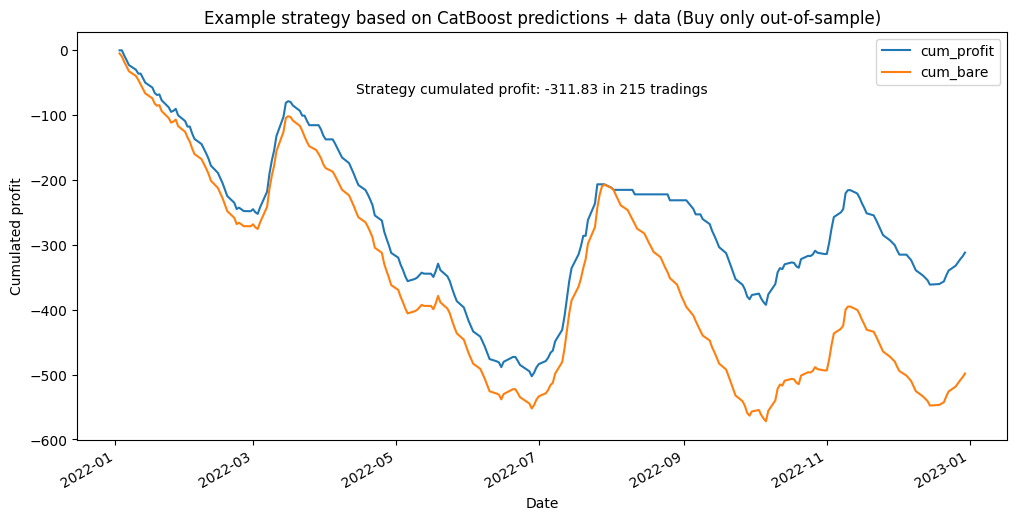

In [144]:
strategy_df[["cum_profit", "cum_bare"]].plot(
    figsize=(12, 6),
    ylabel="Cumulated profit",
    title="Example strategy based on CatBoost predictions + data (Buy only out-of-sample)",
)
ax = plt.gca()
text = f"Strategy cumulated profit: {strategy_df['cum_profit'].iloc[-1]:.2f} in {strategy_df['strategy'].sum()} tradings"
plt.text(0.3, 0.85, text, transform=ax.transAxes)
plt.legend()
plt.show()

## Compare the two predictions

In [145]:
mask_in = (compare_df["bare_rf_pred_in"] - compare_df["mmar_rf_pred_in"]).astype(bool)
mask_out = (compare_df["bare_rf_pred_out"] - compare_df["mmar_rf_pred_out"]).astype(
    bool
)

In [146]:
compare_df[mask_in]

,bare_rf_pred_in,bare_rf_pred_out,mmar_rf_pred_in,mmar_rf_pred_out
16,0,1,1,1
21,1,1,0,1
23,1,1,0,1
36,0,1,1,1
40,0,1,1,1
47,0,0,1,1
50,0,0,1,1
51,1,0,0,1
53,0,0,1,1
55,0,0,1,1


In [147]:
compare_df[mask_in].shape

(53, 4)

In [148]:
# Compare out of sample preds
compare_df[mask_out]

,bare_rf_pred_in,bare_rf_pred_out,mmar_rf_pred_in,mmar_rf_pred_out
2,0,0,0,1
3,1,0,1,1
4,1,0,1,1
5,0,0,0,1
6,0,0,0,1
...,...,...,...,...
246,0,0,1,1
247,1,0,0,1
248,1,0,1,1
249,0,0,0,1


In [149]:
compare_df[mask_out].shape

(170, 4)

In [150]:
compare_df.sum(axis=0)

bare_rf_pred_in     114
bare_rf_pred_out     47
mmar_rf_pred_in     117
mmar_rf_pred_out    215
dtype: int64